In [ ]:
# Praca analizuje dane giełdowe i próbuje przewidzieć zachowanie akcji.
# Po pierwsze dane są wczytywane z użyciem narzędzia do Pandas, 
# więc pozyskiwanie i czyszczenie danych w zasadzie nie istnieje, 
# bo są one wczytywane jedną komendą i od razu w dobrym stanie. 
# Zatem część inżynierii danych jest nieistniejące. 
# Zostały zastosowanie modele uczenia maszynowego ale wg mnie nie do końca poprawnie, 
# bo w modelach szeregów czasowych przewiduje się kolejny krok a nie całość przebiegu na raz. 
#Ponadto np przy sieciach neuronowych opis mówi, że dodano warstwy Dropout a w kodzie są wyłącznie Dense; 
#zresztą do TS stosuje się RNNy czy LSTMy a nie proste sieci. 
#Dodatkowo, co ważne, nie została użyta żądna technologia BD, co było wymagane; jest tylko Pandas, SKlearn i Keras.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import math

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import CSVLogger

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import  train_test_split
from sklearn.cross_validation import cross_val_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import scorer
from sklearn.metrics import accuracy_score

Using TensorFlow backend.
C:\Users\212469077\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName('x').getOrCreate()
stocks = spark.read.option('inferSchema', 'true').option('header', 'true').csv('all_stocks_5yr.csv')
stocks.take(5)

In [2]:
stock_name = 'AMZN'
df = pd.read_csv('all_stocks_5yr.csv')
df = df.drop(['volume'], axis=1)
stock_names = df.Name.unique()

In [3]:
def extract_stock(stock_name):
    df_stock = df.loc[df['Name'] == stock_name]
    df_stock = df_stock.drop(['Name'], axis=1)
    df_stock = df_stock.dropna()
    df_stock['date'] = pd.to_datetime(df_stock['date'])
    df_stock['close'] = pd.to_numeric(df_stock['close'], downcast='float')
    df_stock.set_index('date',inplace=True)
    df_stock.sort_index(inplace=True)
    
    return df_stock

In [4]:
df_stock = extract_stock('MAR')

In [ ]:
############################################################################################
################################### 0. ALL SCRIPTS START ###################################
############################################################################################

In [5]:
df_close = df_stock['close']

In [6]:
df_close = df_close.values.reshape(len(df_close), 1)

In [9]:
df_close.size

1259

In [7]:
df_stock = df_stock.values.reshape(len(df_stock), 4)

In [10]:
df_stock.size

5036

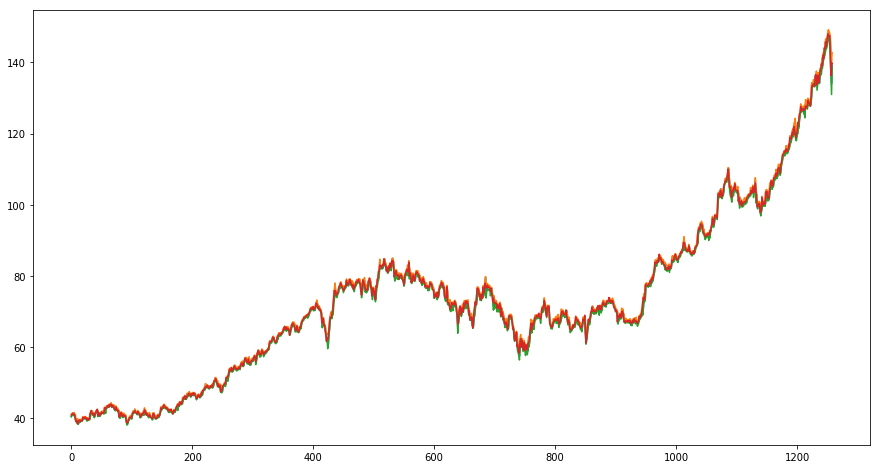

In [13]:
plt.figure(figsize=(15,8))
plt.plot(df_stock)
plt.show()

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
df_stock = scaler.fit_transform(df_stock)
df_stock

array([[0.01850164, 0.01931272, 0.02125901, 0.02229127],
       [0.02251185, 0.02094478, 0.0238303 , 0.02457521],
       [0.02451695, 0.02357421, 0.02502411, 0.02612827],
       ...,
       [0.9325556 , 0.9400671 , 0.90100556, 0.89356835],
       [0.87103536, 0.91857829, 0.85251848, 0.92727931],
       [0.91824645, 0.94160849, 0.92286239, 0.92371638]])

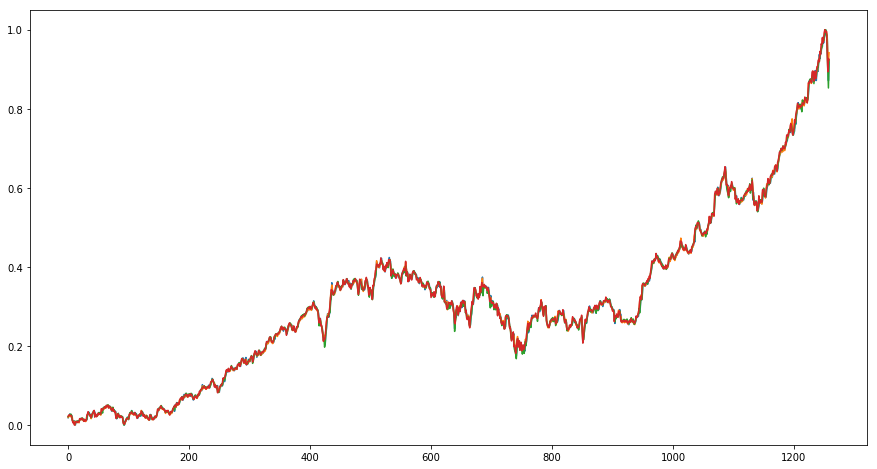

In [15]:
plt.figure(figsize=(15,8))
plt.plot(df_stock)
plt.show()

In [16]:
len(df_stock)

1259

In [17]:
train_size = int(len(df_stock)*0.8)
test_size = len(df_stock) - train_size

df_train, df_test = df_stock[0:train_size, :], df_stock[train_size:len(df_stock), :]

print('Split data into train and test: ', len(df_train), len(df_test))

Split data into train and test:  1007 252


In [18]:
df_train

array([[0.01850164, 0.01931272, 0.02125901, 0.02229127],
       [0.02251185, 0.02094478, 0.0238303 , 0.02457521],
       [0.02451695, 0.02357421, 0.02502411, 0.02612827],
       ...,
       [0.42170981, 0.42252244, 0.42798108, 0.42864969],
       [0.42799854, 0.42442651, 0.43195647, 0.43047689],
       [0.42890995, 0.42991205, 0.43514395, 0.43193857]])

In [19]:
df_test

array([[0.43036821, 0.43122677, 0.43351394, 0.43696326],
       [0.44066715, 0.4356696 , 0.44166399, 0.44089164],
       [0.44194313, 0.43585094, 0.44331696, 0.43778545],
       ...,
       [0.9325556 , 0.9400671 , 0.90100556, 0.89356835],
       [0.87103536, 0.91857829, 0.85251848, 0.92727931],
       [0.91824645, 0.94160849, 0.92286239, 0.92371638]])

In [20]:
def create_ts(ds, series):
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), :]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)

In [33]:
trainX, trainY = create_ts(df_train, series)
testX, testY = create_ts(df_test, series)

In [37]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 4))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 4))

In [38]:
trainX

array([[[0.01850164, 0.01931272, 0.02125901, 0.02229127],
        [0.02251185, 0.02094478, 0.0238303 , 0.02457521],
        [0.02451695, 0.02357421, 0.02502411, 0.02612827],
        ...,
        [0.02205614, 0.02076344, 0.02401396, 0.02402705],
        [0.02451695, 0.02547828, 0.02722806, 0.02466655],
        [0.02415239, 0.02021942, 0.02263648, 0.02101227]],

       [[0.02251185, 0.02094478, 0.0238303 , 0.02457521],
        [0.02451695, 0.02357421, 0.02502411, 0.02612827],
        [0.02807145, 0.02439024, 0.02750356, 0.02420977],
        ...,
        [0.02451695, 0.02547828, 0.02722806, 0.02466655],
        [0.02415239, 0.02021942, 0.02263648, 0.02101227],
        [0.01248633, 0.01885937, 0.01244318, 0.01087157]],

       [[0.02451695, 0.02357421, 0.02502411, 0.02612827],
        [0.02807145, 0.02439024, 0.02750356, 0.02420977],
        [0.02205614, 0.02076344, 0.02401396, 0.02402705],
        ...,
        [0.02415239, 0.02021942, 0.02263648, 0.02101227],
        [0.01248633, 0.018859

In [42]:
#model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 4)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, validation_split=0.25, epochs=50, batch_size=8, verbose=1)

Train on 749 samples, validate on 250 samples
Epoch 1/50
749/749 [==============================] - 2s 2ms/step - loss: 0.0181 - val_loss: 0.0017
Epoch 2/50
749/749 [==============================] - 1s 861us/step - loss: 0.0023 - val_loss: 5.1402e-04
Epoch 3/50
749/749 [==============================] - 1s 924us/step - loss: 3.8413e-04 - val_loss: 1.6897e-04
Epoch 4/50
749/749 [==============================] - 1s 823us/step - loss: 1.2290e-04 - val_loss: 1.4312e-04
Epoch 5/50
749/749 [==============================] - 1s 802us/step - loss: 1.1557e-04 - val_loss: 1.3905e-04
Epoch 6/50
749/749 [==============================] - 1s 762us/step - loss: 1.1402e-04 - val_loss: 1.3842e-04
Epoch 7/50
749/749 [==============================] - 1s 720us/step - loss: 1.1252e-04 - val_loss: 1.4495e-04
Epoch 8/50
749/749 [==============================] - 1s 736us/step - loss: 1.1379e-04 - val_loss: 1.3804e-04
Epoch 9/50
749/749 [==============================] - 1s 792us/step - loss: 1.1487e-04 -

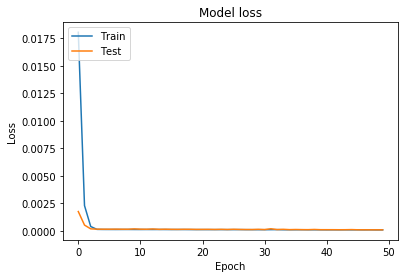

In [43]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

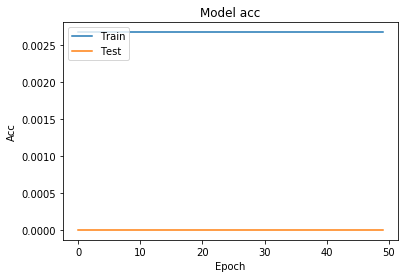

In [41]:
# Plot training & validation loss values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)

In [ ]:
print(str(trainPredictions.size) + ', ' + str(len(trainPredictions)))

In [ ]:
print(str(testPredictions.size) + ', ' + str(len(testPredictions)))

In [ ]:
#predictions
trainPredictions_extended = np.zeros((len(trainPredictions),4))
testPredictions_extended = np.zeros((len(testPredictions),4))

In [ ]:
print(str(trainPredictions_extended.size) + ', ' + str(len(trainPredictions_extended)))

In [ ]:
print(str(testPredictions_extended.size) + ', ' + str(len(testPredictions_extended)))

In [ ]:
trainPredictions_extended[:,3] = trainPredictions[:,0]
testPredictions_extended[:,3] = testPredictions[:,0]

In [ ]:
print(str(trainPredictions_extended.size) + ', ' + str(len(trainPredictions_extended)))

In [ ]:
print(str(testPredictions_extended.size) + ', ' + str(len(testPredictions_extended)))

In [ ]:
trainPredictions = scaler.inverse_transform(trainPredictions_extended)[:,3]
testPredictions = scaler.inverse_transform(testPredictions_extended)[:,3]

In [ ]:
print(str(trainPredictions.size) + ', ' + str(len(trainPredictions)))

In [ ]:
print(str(testPredictions.size) + ', ' + str(len(testPredictions)))

In [ ]:
trainY

In [ ]:
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [ ]:
#accuracy
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)

In [ ]:
#plot
train_plot = np.empty_like(df_close)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(df_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(df_close)-1, :] = testPredictions

#plot on graph
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_close), label='market')
plt.plot(train_plot, label='train')
plt.plot(test_plot, label='test')
plt.grid()
plt.legend()

plt.show()

In [ ]:
#get stock
df_stock = extract_stock(stock_name)

#prepare variables
df_stock['H-L'] = df_stock['high'] - df_stock['low']
df_stock['O-C'] = df_stock['close'] - df_stock['open']
df_stock['3day MA'] = df_stock['close'].shift(1).rolling(window = 3).mean()
df_stock['10day MA'] = df_stock['close'].shift(1).rolling(window = 10).mean()
df_stock['30day MA'] = df_stock['close'].shift(1).rolling(window = 30).mean()
df_stock['Std_dev']= df_stock['close'].rolling(5).std()

#prepare predicted
df_stock['Price_Rise'] = np.where(df_stock['close'].shift(-1) > df_stock['close'], 1, 0)
    
#teach model
csv_logger = CSVLogger('log.csv', append=False, separator=',')
history = classifier.fit(X_train, y_train, batch_size = 10, epochs = 150, verbose = 1, callbacks=[csv_logger], validation_data=(X_test, y_test))

#create metric
score = classifier.evaluate(X_test, y_test, verbose=1)

accuracy_train_ANN = history.history['acc'][-1]
accuracy_test_ANN = score[1]